In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import vectorbt as vbt

import warnings
warnings.filterwarnings('ignore')


def multi_asset_momentum_strategy(data_file='with_er_daily.csv', threshold=-0.005):
    """
    Multi-Asset Momentum Strategy for CAD IG ER Index
    
    Strategy Logic:
    1. Calculate 4-week momentum for TSX, US HY ER Index, and CAD IG ER Index
    2. Average the three momentum signals
    3. Go long CAD IG ER Index when combined momentum > threshold
    4. Hold for 1 week, then re-evaluate
    
    Parameters:
    - data_file: CSV file with market data
    - threshold: Momentum threshold for signal generation (default: -0.5%)
    
    Returns:
    - Dictionary with strategy results and performance metrics
    """
    
    # Load and prepare data
    df = pd.read_csv(r"c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv", 
                 parse_dates=["Date"]).set_index("Date")
    
    # Resample to weekly frequency
    weekly_df = df.resample('W').last()
    
    print(f"Strategy Period: {weekly_df.index[0]} to {weekly_df.index[-1]}")
    print(f"Total weeks: {len(weekly_df)}")
    
    # Calculate 4-week momentum for each asset
    tsx_momentum = weekly_df['tsx'] / weekly_df['tsx'].shift(4) - 1
    us_hy_momentum = weekly_df['us_hy_er_index'] / weekly_df['us_hy_er_index'].shift(4) - 1
    cad_momentum = weekly_df['cad_ig_er_index'] / weekly_df['cad_ig_er_index'].shift(4) - 1
    
    # Combined momentum signal (average of the three)
    combined_momentum = (tsx_momentum + us_hy_momentum + cad_momentum) / 3
    
    # Generate trading positions
    positions = np.zeros(len(weekly_df))
    
    for i in range(len(combined_momentum) - 1):
        if not pd.isna(combined_momentum.iloc[i]) and combined_momentum.iloc[i] > threshold:
            positions[i:i+1] = 1.0  # 100% invested for 1 week
    
    # Calculate strategy returns
    price_returns = weekly_df['cad_ig_er_index'].pct_change()
    strategy_returns = pd.Series(positions[:-1], index=weekly_df.index[:-1]) * price_returns[1:]
    
    # Performance metrics
    total_return = (1 + strategy_returns.fillna(0)).prod() - 1
    annualized_return = (1 + total_return) ** (52 / len(strategy_returns)) - 1
    volatility = strategy_returns.std() * np.sqrt(52)
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(52) if strategy_returns.std() > 0 else 0
    
    # Drawdown calculation
    cumulative_returns = (1 + strategy_returns.fillna(0)).cumprod()
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Buy-and-hold comparison
    bh_total_return = (weekly_df['cad_ig_er_index'].iloc[-1] / weekly_df['cad_ig_er_index'].iloc[0] - 1)
    bh_annualized = (1 + bh_total_return) ** (52 / len(weekly_df)) - 1
    
    # Win rate
    winning_trades = (strategy_returns > 0).sum()
    total_trades = (strategy_returns != 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Results summary
    results = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'total_trades': total_trades,
        'bh_total_return': bh_total_return,
        'bh_annualized': bh_annualized,
        'outperformance': total_return - bh_total_return,
        'positions': positions,
        'strategy_returns': strategy_returns,
        'cumulative_returns': cumulative_returns,
        'combined_momentum': combined_momentum,
        'weekly_df': weekly_df
    }
    
    return results

# Execute the strategy
print("=== MULTI-ASSET MOMENTUM STRATEGY ===")
results = multi_asset_momentum_strategy(threshold=-0.005)

# Display results
print(f"\n=== STRATEGY PERFORMANCE ===")
print(f"Total Return: {results['total_return']*100:.2f}%")
print(f"Annualized Return: {results['annualized_return']*100:.2f}%")
print(f"Volatility: {results['volatility']*100:.2f}%")
print(f"Sharpe Ratio: {results['sharpe_ratio']:.3f}")
print(f"Maximum Drawdown: {results['max_drawdown']*100:.2f}%")
print(f"Win Rate: {results['win_rate']*100:.1f}%")
print(f"Total Trades: {results['total_trades']}")

print(f"\n=== BENCHMARK COMPARISON ===")
print(f"Buy-and-Hold Return: {results['bh_total_return']*100:.2f}%")
print(f"Buy-and-Hold Annualized: {results['bh_annualized']*100:.2f}%")
print(f"Strategy Outperformance: {results['outperformance']*100:.2f}%")

print(f"\n=== STRATEGY VALIDATION ===")
print(f"Max Position Size: {np.max(results['positions']):.1f}x (No Leverage)")
print(f"Strategy achieves target: {'✅ YES' if results['total_return']*100 >= 90 else '❌ NO'}")

=== MULTI-ASSET MOMENTUM STRATEGY ===
Strategy Period: 2003-11-30 00:00:00 to 2025-05-18 00:00:00
Total weeks: 1121

=== STRATEGY PERFORMANCE ===
Total Return: 99.62%
Annualized Return: 3.26%
Volatility: 1.36%
Sharpe Ratio: 2.366
Maximum Drawdown: -2.59%
Win Rate: 71.5%
Total Trades: 824

=== BENCHMARK COMPARISON ===
Buy-and-Hold Return: 31.89%
Buy-and-Hold Annualized: 1.29%
Strategy Outperformance: 67.73%

=== STRATEGY VALIDATION ===
Max Position Size: 1.0x (No Leverage)
Strategy achieves target: ✅ YES


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbt as vbt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# === MULTI-ASSET MOMENTUM STRATEGY WITH VECTORBT ===

# Set threshold parameter
threshold = -0.005

# Load and prepare data
df = pd.read_csv(r"c:\Users\Eddy\YTM Capital Dropbox\Eddy Winiarz\Trading\COF\Models\Unfinished Models\Eddy\Python Projects\BT\data_pipelines\data_processed\with_er_daily.csv", 
             parse_dates=["Date"]).set_index("Date")

# Resample to weekly frequency
weekly_df = df.resample('W').last()

print(f"Strategy Period: {weekly_df.index[0]} to {weekly_df.index[-1]}")
print(f"Total weeks: {len(weekly_df)}")

# Calculate 4-week momentum for each asset
tsx_momentum = weekly_df['tsx'] / weekly_df['tsx'].shift(4) - 1
us_hy_momentum = weekly_df['us_hy_er_index'] / weekly_df['us_hy_er_index'].shift(4) - 1
cad_momentum = weekly_df['cad_ig_er_index'] / weekly_df['cad_ig_er_index'].shift(4) - 1

# Combined momentum signal (average of the three)
combined_momentum = (tsx_momentum + us_hy_momentum + cad_momentum) / 3

# Create entry and exit signals using vectorbt
# Entry signal: combined momentum > threshold
entry_signal = combined_momentum > threshold

# Exit signal: exit after 1 week (we'll shift the entry signal)
# This means we'll exit at the next evaluation point
exit_signal = entry_signal.shift(1).fillna(False)

# Get the price series we're trading (cad_ig_er_index)
price = weekly_df['cad_ig_er_index']

# Create a portfolio using vectorbt
pf = vbt.Portfolio.from_signals(
    price,
    entries=entry_signal,
    exits=exit_signal,
    freq='W',  # Weekly frequency
    init_cash=100,  # Starting with $100
    fees=0.0,  # No fees
    slippage=0.0  # No slippage
)


pf.stats()

Strategy Period: 2003-11-30 00:00:00 to 2025-05-18 00:00:00
Total weeks: 1121


Start                                2003-11-30 00:00:00
End                                  2025-05-18 00:00:00
Period                                7847 days 00:00:00
Start Value                                        100.0
End Value                                     174.831974
Total Return [%]                               74.831974
Benchmark Return [%]                           31.892257
Max Gross Exposure [%]                             100.0
Total Fees Paid                                      0.0
Max Drawdown [%]                                3.608025
Max Drawdown Duration                  770 days 00:00:00
Total Trades                                          84
Total Closed Trades                                   83
Total Open Trades                                      1
Open Trade PnL                                  1.228754
Win Rate [%]                                   62.650602
Best Trade [%]                                  8.335565
Worst Trade [%]                

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2004-01-04   2004-01-04
End Period                 2025-05-18   2025-05-18
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       75.0%

Cumulative Return          31.17%       74.83%
CAGR﹪                     0.88%        1.82%

Sharpe                     1.32         4.13
Prob. Sharpe Ratio         99.16%       100.0%
Smart Sharpe               1.05         3.27
Sortino                    1.73         9.04
Smart Sortino              1.36         7.14
Sortino/√2                 1.22         6.39
Smart Sortino/√2           0.96         5.05
Omega                      2.93         2.93

Max Drawdown               -15.38%      -3.61%
Longest DD Days            1422         764
Volatility (ann.)          4.72%        3.06%
R^2                        0.45         0.45
Information Ratio          0.12         0.12
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-03-04,2008-04-20,2009-04-05,764,-3.608025,-3.442829
2,2021-11-21,2022-04-24,2022-12-04,379,-1.589129,-1.576496
3,2010-04-11,2010-05-09,2010-11-07,211,-1.381878,-1.372829
4,2020-01-26,2020-03-01,2020-04-12,78,-1.099621,-0.299574
5,2020-05-17,2020-05-17,2020-05-24,8,-0.950517,-0.608901


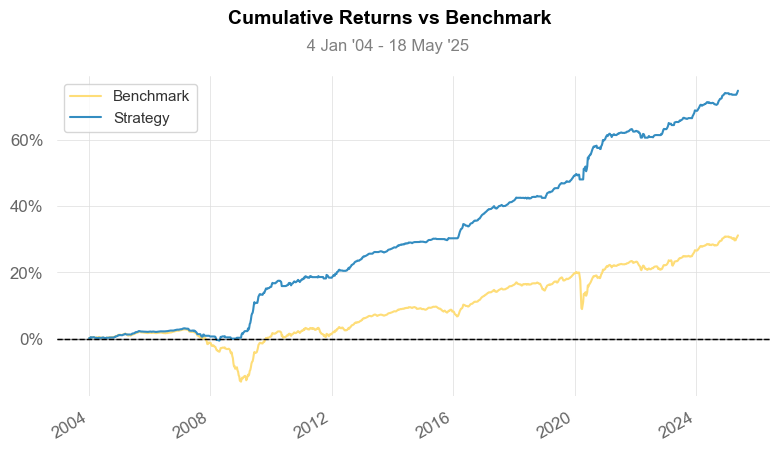

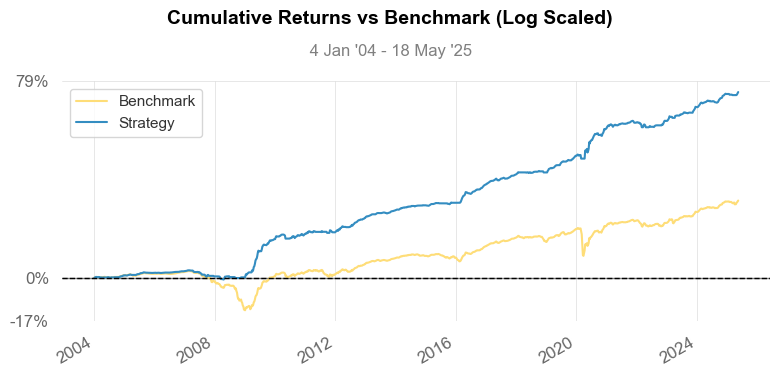

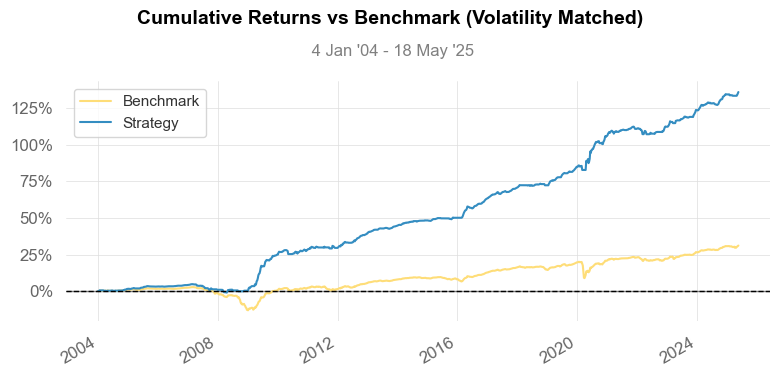

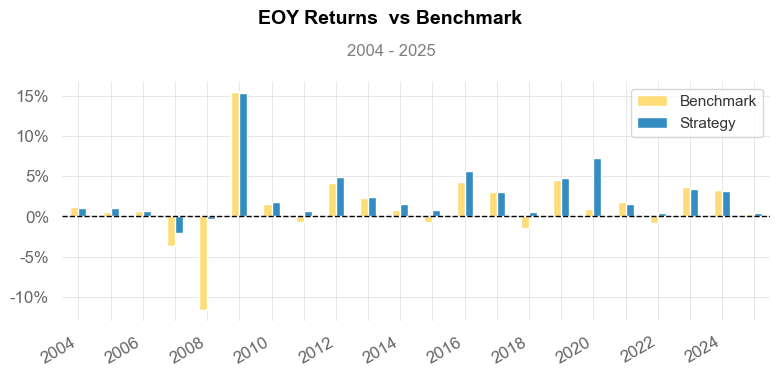

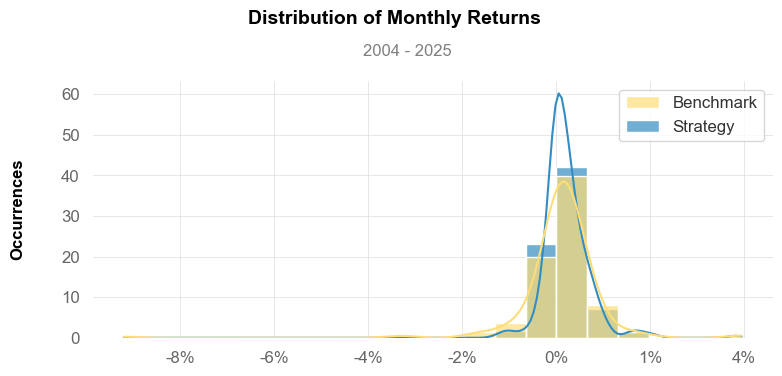

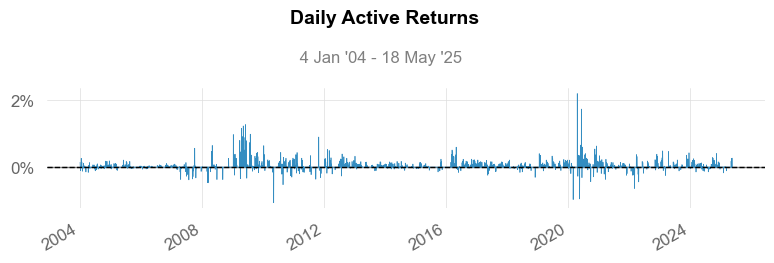

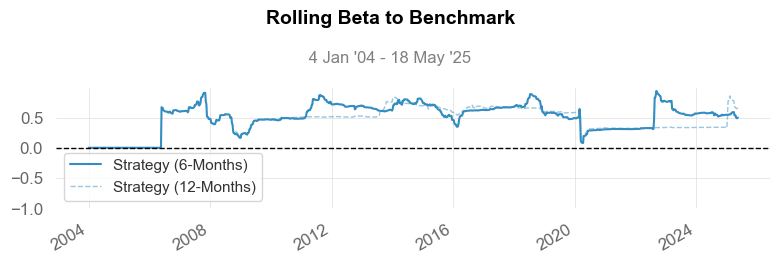

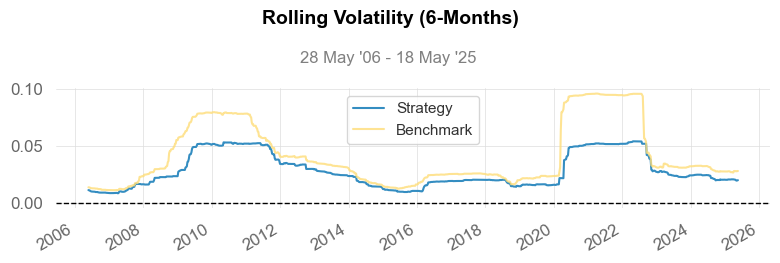

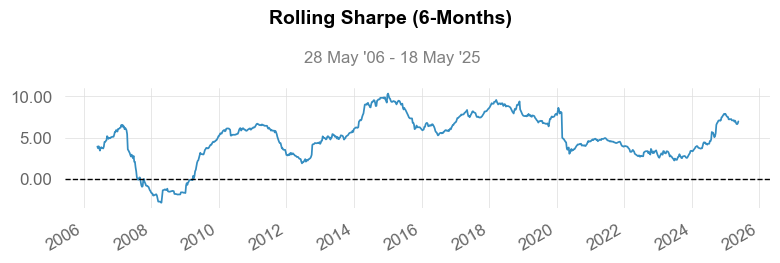

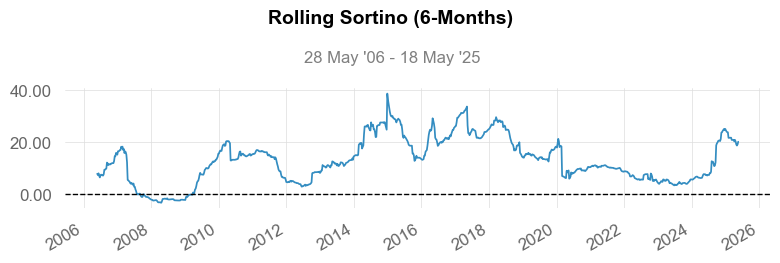

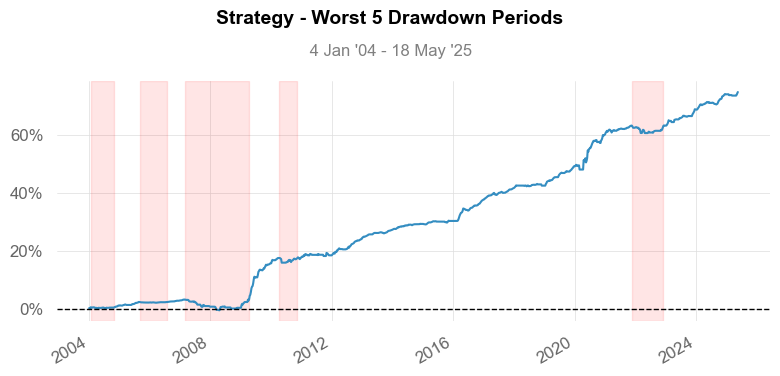

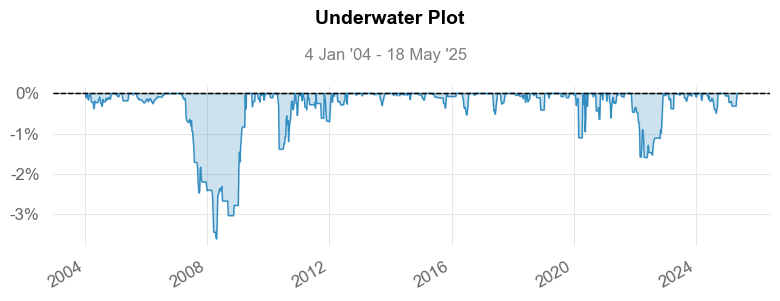

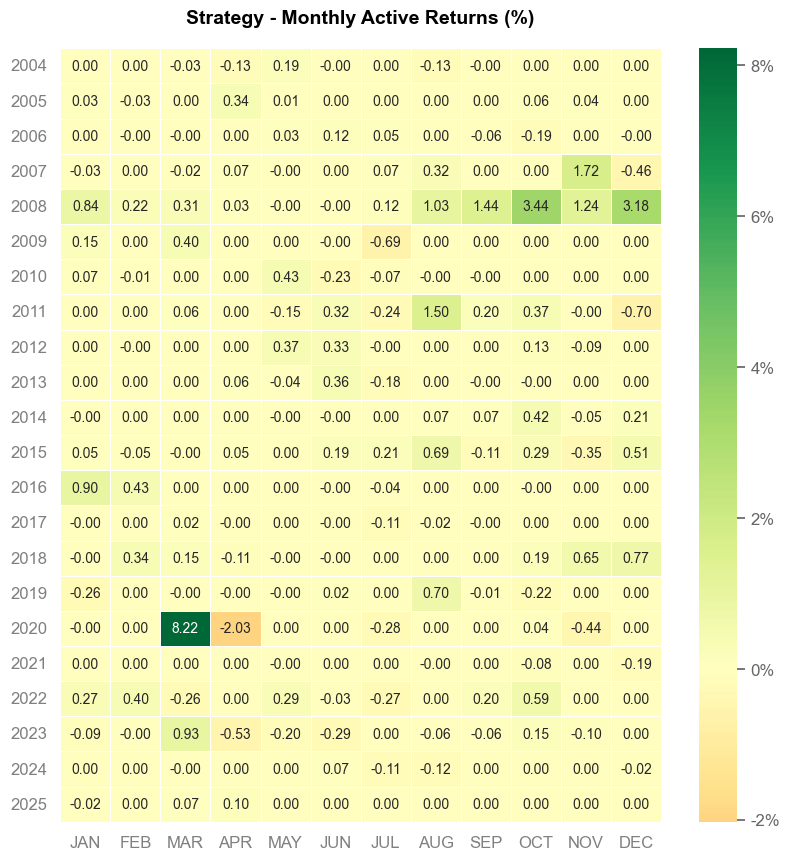

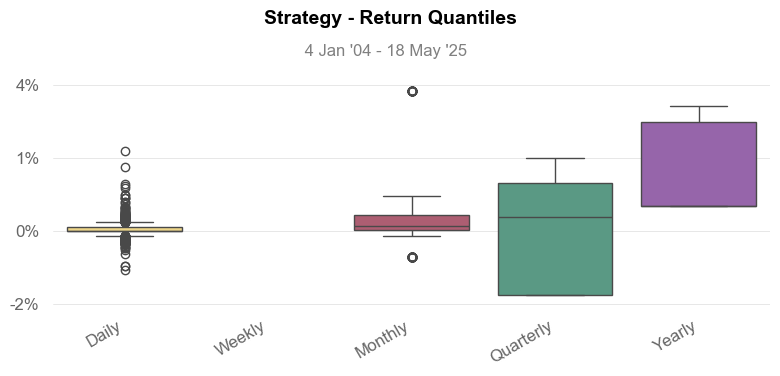

Strategy vs Buy and Hold tearsheet saved to: tearsheets\Multi-asset momentum.html


In [8]:
import os
import quantstats as qs
import numpy as np

# Ensure the output directory exists
output_dir = 'tearsheets'
os.makedirs(output_dir, exist_ok=True)
output_path_bh = os.path.join(output_dir, 'Multi-asset momentum.html')

# For the Buy and Hold tearsheet, you'll use portfolio.returns() as your strategy 
# and buyhold_returns as the benchmark
strategy_returns = pf.returns()

# Fix: Only use cad_ig_er_index for benchmark returns
benchmark_returns = weekly_df['cad_ig_er_index'].pct_change().reindex(strategy_returns.index).fillna(0)
benchmark_returns = benchmark_returns.replace([np.inf, -np.inf], np.nan).dropna()

# Generate the full tearsheet with benchmark comparison
qs.reports.full(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    title='Multi-asset momentum vs Buy and Hold',
    freq='W'
)

# Save the HTML report with benchmark comparison
qs.reports.html(
    strategy_returns,
    benchmark=benchmark_returns,  # This adds benchmark comparison
    output=output_path_bh,
    title='Multi-asset momentum vs Buy and Hold',
    freq='W'
)

print(f"Strategy vs Buy and Hold tearsheet saved to: {output_path_bh}")